# Task 4: Routing


## Reproduction of the task 1 ETL pipeline

The first cells only make sure that the file root is set correct and the database connection is build.

In [2]:
import sys
from pathlib import Path

repo_root = Path("..").resolve()
if repo_root.as_posix() not in sys.path:
    sys.path.insert(0, repo_root.as_posix())

In [3]:
from src.timetable_etl.config import Settings
from src.timetable_etl.db import connect

settings = Settings.from_env()
print(settings)
conn = connect(settings)

Settings(db_host='localhost', db_name='postgres', db_user='postgres', db_password='1234', station_json_path=PosixPath('/Users/rebeccamerdes/Desktop/TU/master/DIA/repo/DIA/DBahn-berlin/repo/station_data.json'), planned_archives_path=PosixPath('/Users/rebeccamerdes/Desktop/TU/master/DIA/repo/DIA/DBahn-berlin/repo/timetables'), changes_archives_path=PosixPath('/Users/rebeccamerdes/Desktop/TU/master/DIA/repo/DIA/DBahn-berlin/repo/timetable_changes'), archive_pattern='*.tar.gz', timezone='Europe/Berlin', match_threshold=0.75, ambiguity_delta=0.02, planned_batch_size=5000, change_batch_size=50000)


## Step 0: Deduplication Investigation

We just wanted to show the we have investigated the duplicate keys exist in the ``stop_id`` attribute and thus, deduplication is necessary.

In [4]:
from src.timetable_etl.dedup_invest import count_stop_id_duplicates
import os
count_stop_id_duplicates(os.path.join(repo_root, "timetables"))

{'files_processed': 135692,
 'stop_id_total': 2104080,
 'stop_id_unique': 2085472,
 'stop_id_duplicates': 18608,
 'duplicate_ids': 18608}

In [5]:
count_stop_id_duplicates(os.path.join(repo_root, "timetable_changes"))

{'files_processed': 540668,
 'stop_id_total': 1686852,
 'stop_id_unique': 1118918,
 'stop_id_duplicates': 567934,
 'duplicate_ids': 360890}

#### Step 1: Build Station Table

The imported function reads the ``stations_data.json`` and builds the station dimension table from it.

In [6]:
from src.timetable_etl.stations import import_stationen

n = import_stationen(conn, settings.station_json_path)
print("Upserted station rows:", n)

Upserted station rows: 133


---

## Task 4-specific adaptions

#### Step 2: Build other Dimension Tables + Fact Table

The imported function builds the other dimension tables. Also, it iterates the ``timetables`` directory and inserts the planned values into the stops table.

In [7]:
from src.timetable_etl.stops_planned import import_stops_from_archives

planned_res = import_stops_from_archives(
    conn,
    settings.planned_archives_path,
    pattern=settings.archive_pattern,
    timezone=settings.timezone,
    match_threshold=settings.match_threshold,
    ambiguity_delta=settings.ambiguity_delta,
    batch_size=settings.planned_batch_size,
)
planned_res

{'archives_processed': 135692,
 'stops_upserted': 2094358,
 'unmatched_stations': []}

In [8]:
# test
conn.rollback() 

query = """
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_name = 'stops';
"""

with conn.cursor() as cur:
    cur.execute(query)
    rows = cur.fetchall()

rows


[('public', 'stops')]

In [9]:
conn.rollback()

with conn.cursor() as cur:
    cur.execute("""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'public'
          AND table_name = 'stops'
        ORDER BY ordinal_position;
    """)
    cols = [r[0] for r in cur.fetchall()]

cols


['stop_id',
 'eva',
 'train_id',
 'arrival_pt_id',
 'departure_pt_id',
 'arrival_ct_id',
 'departure_ct_id',
 'arrival_clt_id',
 'departure_clt_id',
 'arrival_cs',
 'departure_cs',
 'arrival_pp',
 'departure_pp',
 'arrival_cp',
 'departure_cp',
 'stop_sequence_index']

## Step 3: Insert Change Values to Fact Table

The imported function iterates the ``timetable_changes`` directory and updates the stops table accordingly.

In [10]:
from src.timetable_etl.stops_changed import process_change_archives

changed_res = process_change_archives(
    conn,
    settings.changes_archives_path,
    pattern=settings.archive_pattern,
    batch_size=settings.change_batch_size,
)
changed_res


{'archives_processed': 540668, 'stops_updated': 1132029}

### New step: add stop order index

In [11]:
from src.timetable_etl.stop_sequence import ensure_stop_sequence_column

conn.rollback()

ensure_stop_sequence_column(conn)

In [12]:
conn.rollback()
from src.timetable_etl.stop_sequence import compute_stop_sequence

compute_stop_sequence(conn)


### 4.1: Shortest route (graph hops)

In [13]:
# nodes = stations (identified by eva)
# create edges from stop_sequence_index = i -> i+1

from src.timetable_etl.station_graph import build_station_graph

g_station, eva_to_vertex = build_station_graph(conn)

In [14]:
from graph_tool.topology import all_shortest_paths

# todo: change

from_s = eva_to_vertex[8089091]
to_s   = eva_to_vertex[8011160]

paths = list(all_shortest_paths(g_station, from_s, to_s))


In [15]:
eva_prop = g_station.vertex_properties["eva"]

all_paths = [
    [eva_prop[v] for v in path]
    for path in paths
]

for p in all_paths:
    print(p)


[8089091, 8011306, 8011160]


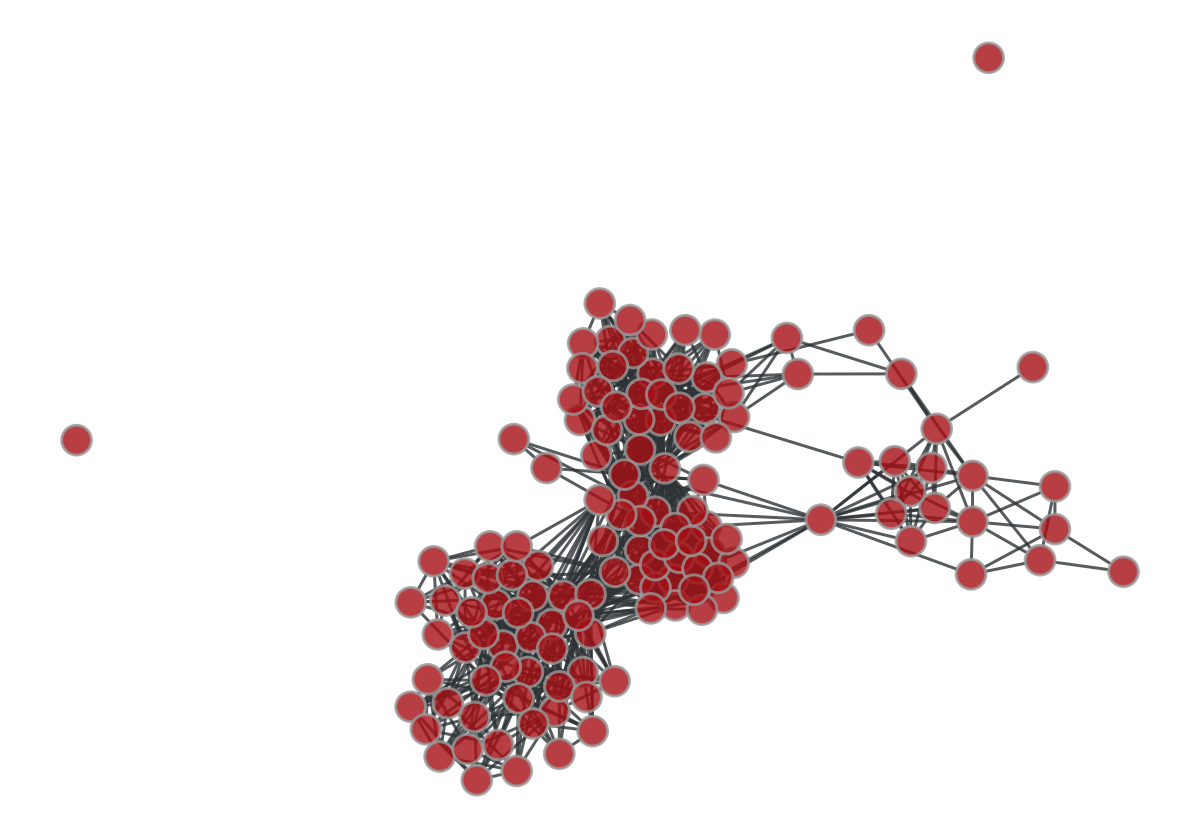

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x11daaabd0, at 0x11db37610>

In [16]:
import graph_tool.all as gt

gt.graph_draw(g_station)


### 4.2: Earliest arrival

In [ ]:
# nodes = stations (eva) and trips
# edges = departure edge and arrival edge

In [ ]:
conn.close()